# Implementação de modelo de segmentação para talhonamento

## Pré-processamento de Imagens

As imagens recebidas do parceiro são de 1200x1200 pixels. Redimensionamos essas imagens para 1280x1280 pixels e, em seguida, recortamos em pedaços de 256x256 pixels. Após o recorte, as imagens são salvas e processadas pelo modelo.

O processo de recorte é automatizado conforme descrito no pseudocódigo a seguir. Cada imagem de máscara e TIFF é carregada e redimensionada para 1280x1280 pixels. Em seguida, o nome da imagem é extraído para criar um diretório específico onde os recortes serão armazenados. As imagens são então divididas em uma grade de 5x5, gerando 25 recortes de 256x256 pixels. Cada recorte é salvo em um diretório correspondente com um número identificador, tanto para a máscara quanto para a imagem TIFF.

Esse processo garante que as imagens estejam no formato adequado para o modelo, facilitando a análise subsequente.

Segue o link do notebook implementado:
https://github.com/Inteli-College/2024-1B-T01-CC10-G02/blob/main/codigo/notebooks/SPRINT%205/Crop_imagens_v2.ipynb

## Data Augmentation

O processo de data augmentation foi descrito e implementado durante a evolução das demais sprints do projeto, e pode ser encontrado no notebook com o link abaixo:

https://github.com/Inteli-College/2024-1B-T01-CC10-G02/blob/main/codigo/notebooks/SPRINT%204/DATA%20AUGMENTATION/Sprint04_data_augmentation_com_processamento_imagem.ipynb

## Modelo de Segmentação

### Importando bibliotecas

In [ ]:
!pip install tensorflow_model_optimization

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from google.colab import drive
import pandas as pd
import random
import os
import time
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from glob import glob
from sklearn.model_selection import train_test_split
import numpy as np
from keras import layers, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import tensorflow as tf
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

### Usando carregamento em lote

Aqui está uma breve descrição em Markdown sobre o que está sendo implementado:

A classe `CarregamentoLote` herda de `Sequence` e é utilizada para carregar e processar lotes de imagens e suas respectivas máscaras em um dataset. Esta classe facilita o carregamento em mini-lotes durante o treinamento de um modelo de aprendizado de máquina.

### Métodos Implementados

- `__init__(self, entradas, saidas, batch_size)`: Inicializa a classe com as entradas (caminhos das imagens de entrada), saídas (caminhos das máscaras) e o tamanho do lote (batch size).

- `__len__(self)`: Retorna a quantidade de lotes no dataset, calculada dividindo o tamanho total do dataset pelo tamanho do lote.

- `__getitem__(self, id)`: Retorna um lote de entradas e saídas baseado no índice fornecido. Este método:
  - Define os índices de início e fim do lote.
  - Carrega e redimensiona as imagens de entrada para um tamanho de 256x256.
  - Carrega, redimensiona e normaliza as máscaras de saída para um tamanho de 256x256, aplicando uma binarização com limiar de 0.5.

### Processamento das Imagens

- **Imagens de Entrada**:
  - São carregadas usando o caminho fornecido concatenado com `'image.tif'`.
  - São redimensionadas para 256x256.

- **Máscaras de Saída**:
  - São carregadas usando o caminho fornecido concatenado com `'mask.png'`.
  - São redimensionadas para 256x256.
  - São normalizadas entre 0 e 1.
  - São binarizadas com um limiar de 0.5, convertendo valores abaixo do limiar para 0 e acima para 1.

Esta classe é essencial para a preparação de dados durante o treinamento de modelos que exigem um processamento eficiente de imagens e suas respectivas máscaras, garantindo que os dados sejam fornecidos em mini-lotes.



In [ ]:
class CarregamentoLote(Sequence):

    def __init__(self, entradas, saidas, batch_size):
        self.entradas = entradas
        self.saidas = saidas
        self.batch_size = batch_size

    def __len__(self):
        # Calcula a quantidade de lotes com base no tamanho do dataset e do lote
        return len(self.entradas) // self.batch_size

    def __getitem__(self, id):
        # Define os índices para o lote atual
        esquerda = id * self.batch_size
        direita = min(esquerda + self.batch_size, len(self.entradas))

        # Obtém os lotes de entradas e saídas
        batch_entradas = self.entradas[esquerda:direita]
        batch_saidas = self.saidas[esquerda:direita]

        # Redimensiona as imagens de entrada
        entradas_redimensionadas = []
        for caminho_img in tqdm(batch_entradas, desc="Processando entradas", unit="imagem"):
            img_entrada = imread(caminho_img + 'image.tif')
            img_redimensionada_entrada = resize(img_entrada, (256, 256))
            entradas_redimensionadas.append(img_redimensionada_entrada)

        # Redimensiona e normaliza as máscaras de saída
        saidas_redimensionadas = []
        for caminho_img in tqdm(batch_saidas, desc="Processando saídas", unit="imagem"):
            img_saida = imread(caminho_img + 'mask.png')
            img_redimensionada_saida = resize(img_saida, (256, 256))
            img_redimensionada_saida = np.array(img_redimensionada_saida)

            # Normaliza a máscara de saída
            min_val = np.min(img_redimensionada_saida)
            max_val = np.max(img_redimensionada_saida)
            img_redimensionada_saida = (img_redimensionada_saida - min_val) / (max_val - min_val)

            # Aplica o limiar para binarização
            threshold = 0.5
            img_redimensionada_saida = tf.where(img_redimensionada_saida < threshold, 0.0, 1.0)
            saidas_redimensionadas.append(img_redimensionada_saida)

        return np.array(entradas_redimensionadas), np.array(saidas_redimensionadas)

In [ ]:
caminhos = glob('/content/drive/Shareddrives/Grupo T de Tech/Data/dataset_inteli_test/new_cropped/imagens_parceiro/*/*/')
np.random.shuffle(caminhos)

In [ ]:
sequencia = CarregamentoLote(caminhos, caminhos, 1024)

In [ ]:
primeiro_lote_entradas, primeiro_lote_saidas = sequencia.__getitem__(0)

In [ ]:
primeiro_lote_entradas.shape

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(primeiro_lote_entradas, primeiro_lote_saidas, test_size=0.3, random_state=42)

# Definição de parâmetros

In [ ]:
class CyclicLR(Callback):
    def __init__(self, base_lr=1e-4, max_lr=1e-3, step_size=2000., mode='triangular'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.iterations / (2 * self.step_size))
        x = np.abs(self.iterations / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x))
        if self.mode == 'triangular2':
            lr = lr / float(2 ** (cycle - 1))
        elif self.mode == 'exp_range':
            lr = lr * (0.999 ** self.iterations)
        return lr

    def on_train_begin(self, logs=None):
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)

    def on_batch_end(self, batch, logs=None):
        self.iterations += 1
        lr = self.clr()
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.history.setdefault('lr', []).append(lr)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

# Função de callbacks
def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    clr = CyclicLR(base_lr=1e-4, max_lr=1e-3, step_size=2000., mode='triangular2')
    return [early_stopping, reduce_lr, clr]


In [ ]:
# Função para calcular a sigmoide e converter para 0 ou 1 o output
class ThresholdLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.where(inputs < 0.5, 0.0, 1.0)

# Função para calcular o Dice Coefficient
def dice_coefficient(y_train, y_val):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_train * y_val)
    dice_coefficient = (2. * intersection + smooth) / (tf.reduce_sum(y_train) + tf.reduce_sum(y_val) + smooth)
    return dice_coefficient

# Função de perda de Dice
def dice_loss(y_train, y_val):
    return 1 - dice_coefficient(y_train, y_val)

# Função para calcular a penalidade adicional
def penalty_loss(y_train, y_val, penalty_weight):
    # Calcular a penalidade considerando a diferença entre y_train e y_val
    penalty = tf.reduce_sum(tf.abs(y_train - y_val))
    # Multiplicar a penalidade pelo peso da penalidade
    weighted_penalty = penalty_weight * penalty
    return weighted_penalty

# Função de perda combinada
def combined_loss(y_train, y_val, alpha, beta, gamma, penalty_weight):
    # Perda padrão (por exemplo, perda de entropia cruzada binária)
    standard_loss = tf.keras.losses.binary_crossentropy(y_train, y_val)
    dice = dice_loss(y_train, y_val) # Dice Loss
    penalty = penalty_loss(y_train, y_val, penalty_weight) # Penalidade adicional
    # Perda total = perda padrão + penalidade + Dice Loss
    total_loss = alpha * standard_loss + beta * dice + gamma * penalty
    return total_loss

# Métrica de acurácia customizada
def custom_accuracy(y_train, y_val):
    # Calcular a acurácia considerando uma tolerância de 0.5 na predição
    y_val_binary = tf.round(y_val)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_train, y_val_binary), tf.float32))
    return accuracy

# Modelo Pré-treinado MobileNetV2

O modelo que utilizamos para fazer o transfer learning é o MobileNetV2, que pode ser encontrado o artigo de sua publicação no link:
https://doi.org/10.48550/arXiv.1801.04381

In [ ]:
# Carregar o modelo MobileNetV2 pré-treinado
pre_trained_model = MobileNetV2(weights='imagenet', include_top=False)

# Visualizar a estrutura do modelo
pre_trained_model.summary()

In [ ]:
class UNet:
    def __init__(self, input_shape, num_filters, kernel_size, dropout_rate, val_reg):
        self.input_shape = input_shape
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.val_reg = val_reg

    def build_model(self):
        inputs = tf.keras.Input(shape=self.input_shape)
        reg = regularizers.L2(self.val_reg)

        # Encoder (contraction path)
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
        base_model.trainable = False

        # Extract specific layers for connections
        conv2 = base_model.get_layer('block_1_expand').output
        conv3 = base_model.get_layer('block_3_expand').output
        decoded = base_model.get_layer('block_6_expand').output

        # Decoder (expansion path)
        up5 = layers.Conv2DTranspose(self.num_filters[2], (2, 2), strides=(2, 2), padding='same')(decoded)
        merge5 = layers.concatenate([conv3, up5], axis=3)
        conv5 = layers.Conv2D(self.num_filters[2], self.kernel_size, activation='relu', padding='same')(merge5)
        conv5 = layers.Conv2D(self.num_filters[2], self.kernel_size, activation='relu', padding='same')(conv5)

        up6 = layers.Conv2DTranspose(self.num_filters[1], (2, 2), strides=(2, 2), padding='same')(conv5)
        merge6 = layers.concatenate([conv2, up6], axis=3)
        conv6 = layers.Conv2D(self.num_filters[1], self.kernel_size, activation='relu', padding='same')(merge6)
        conv6 = layers.Conv2D(self.num_filters[1], self.kernel_size, activation='relu', padding='same')(conv6)

        up7 = layers.Conv2DTranspose(self.num_filters[0], (2, 2), strides=(2, 2), padding='same')(conv6)
        conv7 = layers.Conv2D(self.num_filters[0], self.kernel_size, activation='relu', padding='same')(up7)
        conv7 = layers.Conv2D(self.num_filters[0], self.kernel_size, activation='relu', padding='same')(conv7)

        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)  # Saída com um canal (máscara binária)

        threshold_output = ThresholdLayer()(outputs)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

    def compile_and_train(self, X_train, y_train, X_val, y_val, max_epochs, batch_size, alpha, beta, gamma, penalty_weight):
        model = self.build_model()
        callbacks = get_callbacks()

        # Compilar o modelo
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=lambda y_train, y_val: combined_loss(y_train, y_val, alpha, beta, gamma, penalty_weight),
                      metrics=[custom_accuracy])

        start_time = time.time()

        # Treinar o modelo
        H = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                      epochs=max_epochs, batch_size=batch_size, callbacks=callbacks)

        # Salvar o tempo de treino
        training_time_gpu = time.time() - start_time

        return H, training_time_gpu, model


In [ ]:
def evaluate_model(model, X_val, y_val, H, training_time_gpu, max_epochs):
    plt.style.use("ggplot")
    plt.figure(figsize=(12, 10))

    start_time = time.time()

    results = model.evaluate(X_val, y_val)

    inference_time_gpu = time.time() - start_time

    print("Test Loss:", results[0])
    print("Test Accuracy:", results[1])

    # Prever máscaras usando o modelo
    predicted_masks = model.predict(X_val)

    # Obter métricas de precisão e perda do treinamento
    acc = H.history['custom_accuracy']
    val_acc = H.history['val_custom_accuracy']
    loss = H.history['loss']
    val_loss = H.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotar precisão do conjunto
    plt.subplot(2, 2, 3)
    plt.plot(epochs, acc, 'r', label='Precisão do Conjunto de Treino')
    plt.plot(epochs, val_acc, 'b', label='Precisão do Conjunto de Validação')
    plt.title('Precisão do Conjunto de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Precisão')
    plt.legend()

    # Plotar perda do conjunto
    plt.subplot(2, 2, 4)
    plt.plot(epochs, loss, 'r', label='Perda do Conjunto de Treino')
    plt.plot(epochs, val_loss, 'b', label='Perda do Conjunto de Validação')
    plt.title('Perda do Conjunto de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print('Tempo de treino (segundos): ', training_time_gpu)
    print('Tempo de treino por época (segundos): ', training_time_gpu / max_epochs)
    print('Tempo de inferência (segundos): ', inference_time_gpu)

    return predicted_masks, inference_time_gpu

# Estudo de Hiperparâmetros - Função de Perda

Tendo em vista a possibilidade de gerar um treino mais estável e que foque precisamente na tarefa de segmentar talhões, foi conduzido um estudo com Grid Search para encontrar os melhores valores de alfa, beta, gama e penalty_weight, valores estes que compõem a função de perda combinada, sendo alfa o fator multiplicativo da função de perda binary_crossentropy, beta o fator da dice loss e gama o fator da penalidade adicional (penalty_weight)

In [ ]:
# Grid de parâmetros para busca
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'beta': [0.1, 1.0],
    'gamma': [0.0001, 0.001, 0.01],
    'penalty_weight': [0.0001, 0.001]
}

grid = ParameterGrid(param_grid)

max_epochs = 30
results = []

test_counter = 1
H_dict = {}
training_time_dict = {}
model_dict = {}

for params in grid:
    print(f'Teste {test_counter}: Testando com parâmetros: {params}')
    model = UNet(input_shape=(256, 256, 3),
                 num_filters=(16, 32, 64, 128),
                 kernel_size = 3,
                 dropout_rate=0.1,
                 val_reg=0.01)

    # Compilar e treinar o modelo com os parâmetros do grid search
    H, training_time_gpu, model = model.compile_and_train(X_train, y_train, X_val, y_val,
                                                          max_epochs=max_epochs,
                                                          batch_size=16,
                                                          alpha=params['alpha'],
                                                          beta=params['beta'],
                                                          gamma=params['gamma'],
                                                          penalty_weight=params['penalty_weight'])

    H_dict[f'H{test_counter}'] = H
    training_time_dict[f'training_time_gpu{test_counter}'] = training_time_gpu
    model_dict[f'model{test_counter}'] = model

    predicted_masks, inference_time_gpu = evaluate_model(model, X_val, y_val, H, training_time_gpu, max_epochs=max_epochs)
    val_loss = H.history['val_loss'][-1]
    val_acc = H.history['val_custom_accuracy'][-1]
    results.append((params, val_loss, val_acc))
    test_counter += 1

Dessa forma, é possível compreender que o teste número 32 possui a maior acurácia, próximo a 84%, com um treinamento estável. As imagens resultantes da predição do modelo podem ser encontradas na seção a seguir.
Cabe ressaltar que, com esse teste, a configuração da função de perda será:

Teste 32: Testando com parâmetros: {'alpha': 10.0, 'beta': 1.0, 'gamma': 0.0001, 'penalty_weight': 0.001}

# Modelo Final com Transfer Learning - MobileNetV2

## Treino e inferência com CPU

Para esse teste com a CPU, é preciso apenas alocar uma máquina qualquer no colab, executar as células do início do notebook até o código abaixo.

In [ ]:
max_epochs = 100

model = UNet(input_shape=(256, 256, 3),
                num_filters=(16, 32, 64, 128),
                kernel_size = 3,
                dropout_rate=0.1,
                val_reg=0.01)

# Compilar e treinar o modelo
H, training_time_gpu, model = model.compile_and_train(X_train, y_train, X_val, y_val,
                                                        max_epochs=max_epochs,
                                                        batch_size=16,
                                                        alpha=10.0,
                                                        beta=1.0,
                                                        gamma=0.0001,
                                                        penalty_weight=0.001)

predicted_masks, inference_time_gpu = evaluate_model(model, X_val, y_val, H, training_time_gpu, max_epochs=max_epochs)

## Treino e inferência com GPU
Para fazer esse teste conecte uma máquina do colab que possua GPU. Embaixo de compartilhar, no canto superior direito está escrito "Conect". Clique na seta para baixo ao lado de conectar. Selecione "Change runtime type" e selecione uma máquina que tenha GPU no nome. A que utilizamos foi a T4 GPU. Após isso, execute as células do início do notebook até o código abaixo.

In [ ]:
max_epochs = 200

model = UNet(input_shape=(256, 256, 3),
                num_filters=(16, 32, 64, 128),
                kernel_size = 3,
                dropout_rate=0.1,
                val_reg=0.01)

with tf.device('/gpu:0'):
    # Compilar e treinar o modelo
    H, training_time_gpu, model = model.compile_and_train(X_train, y_train, X_val, y_val,
                                                            max_epochs=max_epochs,
                                                            batch_size=16,
                                                            alpha=10.0,
                                                            beta=1.0,
                                                            gamma=0.0001,
                                                            penalty_weight=0.001)

    predicted_masks, inference_time_gpu = evaluate_model(model, X_val, y_val, H, training_time_gpu, max_epochs=max_epochs)


## Amostragem das máscaras e IoU

In [ ]:
with tf.device('/gpu:0'):
    # Gerar as saídas do modelo para um conjunto de entradas de teste
    saidas_modelo1Net = model.predict(X_val)

    # Iterar sobre cada saída do modelo
    for i in range(len(X_val)):
        # Obter a entrada correspondente e a saída real
        img_entrada = X_val[i]
        img_saida_real = y_val[i]

        # Obter a saída gerada pelo modelo
        #img_saida_modelo1Net = saidas_modelo1Net[i]
        img_saida_modelo1Net = np.where(saidas_modelo1Net[i] < 0.5, 0, 1)

        # Mostrar as imagens
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_entrada.squeeze(), cmap='gray')
        plt.title('Entrada')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img_saida_real.squeeze(), cmap='gray')
        plt.title('Saída Esperada')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(img_saida_modelo1Net.squeeze(), cmap='gray')
        plt.title('Saída do Modelo - GPU')
        plt.axis('off')

        plt.show()

In [ ]:
with tf.device('/gpu:0'):
    # Métricas do parceiro de Projeto:

    # Lista para armazenar os scores de IoU
    iou_scores = []
    # Calcular IoUs e determinar predições corretas
    correct_predictions = 0
    iou_threshold = 0.5
    for mask, result in zip(y_val, saidas_modelo1Net):
        intersection = np.logical_and(mask, result)
        union = np.logical_or(mask, result)
        iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
        iou_scores.append(iou_score)
        # Verificar se a predição é considerada correta (IoU >= threshold)
        if iou_score >= iou_threshold:
            correct_predictions += 1
        print('IoU é: ' + str(iou_score))
    # Calcular a média dos IoUs
    iou_mean = np.mean(iou_scores)
    print('Média dos IoU - GPU:', iou_mean)
    # Calcular Coverage Ratio (CovR)
    total_predictions = len(iou_scores)
    covr = correct_predictions / total_predictions if total_predictions > 0 else 0
    print('Coverage Ratio (CovR) - GPU:', covr)

# Testes com novas imagens

## Importando as imagens

In [ ]:
import os
import cv2
import numpy as np

def load_masks(masks_dir, target_size=(1280, 1280), crop_size=(256, 256)):
    masks = []
    mask_filenames = []
    ordered_masks = sorted(os.listdir(masks_dir))
    for mask_name in ordered_masks:
        mask_path = os.path.join(masks_dir, mask_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            if mask.shape[:2] != target_size:
                mask = cv2.resize(mask, target_size[::-1], interpolation=cv2.INTER_NEAREST)
            cropped_masks = crop_image(mask, crop_size)
            normalized_masks = [crop / 255.0 for crop in cropped_masks]
            masks.extend(normalized_masks)
            mask_filenames.extend([f"{os.path.splitext(mask_name)[0]}_crop_{i}" for i in range(len(normalized_masks))])
        else:
            print(f"Failed to load mask: {mask_path}")
    return masks, mask_filenames

def load_images(image_dir, target_size=(1280, 1280), crop_size=(256, 256)):
    images = []
    image_filenames = []
    ordered_images = sorted(os.listdir(image_dir))
    for image_name in ordered_images:
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if image.shape[:2] != target_size:
                image = cv2.resize(image, target_size[::-1])
            cropped_images = crop_image(image, crop_size)
            normalized_images = [crop / 255.0 for crop in cropped_images]
            images.extend(normalized_images)
            image_filenames.extend([f"{os.path.splitext(image_name)[0]}_crop_{i}" for i in range(len(normalized_images))])
        else:
            print(f"Failed to load image: {image_path}")
    return images, image_filenames

def crop_image(image, crop_size=(256, 256)):
    crops = []
    steps = [(0, 0), (0, image.shape[1] - crop_size[1]), (image.shape[0] - crop_size[0], 0),
             (image.shape[0] - crop_size[0], image.shape[1] - crop_size[1]),
             ((image.shape[0] - crop_size[0]) // 2, (image.shape[1] - crop_size[1]) // 2)]
    for (i, j) in steps:
        crop = image[i:i + crop_size[0], j:j + crop_size[1]]
        crops.append(crop)
    return crops

# Paths
masks_dir = '/content/drive/Shared drives/Grupo T de Tech/Data/dataset_inteli_test/masks'
image_dir = '/content/drive/Shared drives/Grupo T de Tech/Data/dataset_inteli_test/tci_tifs'

# Load images and masks
masks_test, mask_filenames = load_masks(masks_dir)
images_test, image_filenames = load_images(image_dir)


In [ ]:
# verificando o tamanho correto
len(images_test)

In [ ]:
# Ensure the images are in the correct format for model prediction
images_test = np.array(images_test)

# Gerar as saídas do modelo para um conjunto de entradas de teste
saidas_novas_imagens_modelo = model.predict(images_test)

In [ ]:
with tf.device('/gpu:0'):
    # Iterar sobre cada saída do modelo
    for i in range(len(images_test)):
        # Obter a entrada correspondente e a saída real
        img_entrada = images_test[i]
        img_saida_real = masks_test[i]

        # Obter a saída gerada pelo modelo
        img_saida_modelo = saidas_novas_imagens_modelo[i]

        # Mostrar as imagens
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_entrada.squeeze(), cmap='gray')
        plt.title('Entrada')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img_saida_real.squeeze(), cmap='gray')
        plt.title('Saída Esperada')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(img_saida_modelo.squeeze(), cmap='gray')
        plt.title('Saída do Modelo - GPU')
        plt.axis('off')

        plt.show()

In [ ]:
with tf.device('/gpu:0'):
    # Métricas do parceiro de Projeto:

    # Lista para armazenar os scores de IoU
    iou_scores = []
    # Calcular IoUs e determinar predições corretas
    correct_predictions = 0
    iou_threshold = 0.5
    for mask, result in zip(masks_test, saidas_novas_imagens_modelo):
        intersection = np.logical_and(mask, result)
        union = np.logical_or(mask, result)
        iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 0
        iou_scores.append(iou_score)
        # Verificar se a predição é considerada correta (IoU >= threshold)
        if iou_score >= iou_threshold:
            correct_predictions += 1
        print('IoU é: ' + str(iou_score))
    # Calcular a média dos IoUs
    iou_mean = np.mean(iou_scores)
    print('Média dos IoU - GPU:', iou_mean)
    # Calcular Coverage Ratio (CovR)
    total_predictions = len(iou_scores)
    covr = correct_predictions / total_predictions if total_predictions > 0 else 0
    print('Coverage Ratio (CovR) - GPU:', covr)

# Matriz de Risco

In [ ]:
# Converter 'y_val' para binário também, se necessário
y_val_bin = np.where(y_val < 0.5, 0, 1).reshape(-1)

# Achatar as saídas preditas para cálculo da matriz de confusão
saidas_modelo1Net_flat = saidas_modelo1Net.reshape(-1)

# Calcular a matriz de confusão
cm = confusion_matrix(y_val_bin, saidas_modelo1Net_flat)

# Calcular precisão, recall e F1-score
precision = precision_score(y_val_bin, saidas_modelo1Net_flat)
recall = recall_score(y_val_bin, saidas_modelo1Net_flat)
f1 = f1_score(y_val_bin, saidas_modelo1Net_flat)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

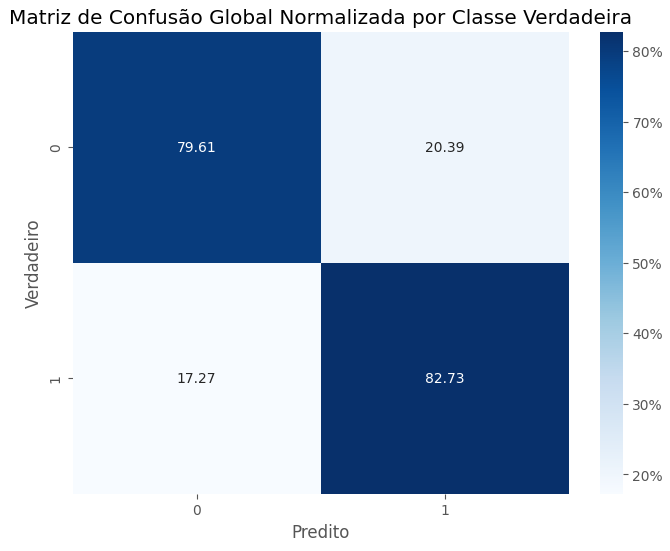

# Pós processamento

In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

import numpy as np
import cv2
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax
from sklearn.metrics import jaccard_score
from tqdm import tqdm

def postprocess_mask_with_crf(image, mask, crf_params):
    softmax = np.stack([1 - mask, mask], axis=-1)
    softmax = np.ascontiguousarray(softmax.transpose(2, 0, 1))
    image = np.ascontiguousarray(image)
    image_uint8 = (image * 255).astype(np.uint8)
    d = dcrf.DenseCRF2D(image.shape[1], image.shape[0], 2)
    unary = unary_from_softmax(softmax)
    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=crf_params['sxy'], compat=crf_params['compat'])
    d.addPairwiseBilateral(sxy=crf_params['sxy_bilateral'], srgb=crf_params['srgb'], rgbim=image_uint8, compat=crf_params['compat_bilateral'])
    Q = d.inference(5)
    refined_mask = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))
    return refined_mask / 255.0

best_crf_params = {
    'sxy': 5,
    'compat': 3,
    'sxy_bilateral': 81,
    'srgb': 10,
    'compat_bilateral': 20
}

# Cálculo para operações morfológicas
def postprocess_mask_with_morphology(mask, morph_params):
    refined_mask = (mask * 255).astype(np.uint8)
    kernel = cv2.getStructuringElement(morph_params['shape'], morph_params['kernel_size'])
    if morph_params['operation'] == 'open':
        refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, kernel, iterations=morph_params['iterations'])
    elif morph_params['operation'] == 'close':
        refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel, iterations=morph_params['iterations'])
    elif morph_params['operation'] == 'dilate':
        refined_mask = cv2.dilate(refined_mask, kernel, iterations=morph_params['iterations'])
    elif morph_params['operation'] == 'erode':
        refined_mask = cv2.erode(refined_mask, kernel, iterations=morph_params['iterations'])
    return refined_mask / 255.0

best_morph_params = {
    'kernel_size': (3,3),
    'iterations': 1,
    'operation': 'dilate',
    'shape': cv2.MORPH_CROSS
}

def morphology_then_crf(image, mask, morph_params, crf_params):
    morph_mask = postprocess_mask_with_morphology(mask, morph_params)
    refined_mask = postprocess_mask_with_crf(image, morph_mask, crf_params)
    return refined_mask

In [ ]:
# Pós-processar as máscaras preditas com CRF denso
saidas_modelo_postprocessed = np.array([morphology_then_crf(images_test[i], saidas_novas_imagens_modelo[i].squeeze(), best_morph_params, best_crf_params) for i in range(len(saidas_novas_imagens_modelo))])

In [ ]:
# Converter as máscaras de teste para binário (0 e 1)
masks_test_binary = (np.array(masks_test) > 0).astype(np.uint8)
saidas_modelo_postprocessed_binary = (saidas_modelo_postprocessed > 0).astype(np.uint8)

# Calcular Jaccard Score
jaccard_scores = [jaccard_score(masks_test_binary[i].flatten(), saidas_modelo_postprocessed_binary[i].flatten(), average='binary') for i in range(len(masks_test))]
print(f"Jaccard Score: {np.mean(jaccard_scores)}")


In [ ]:
with tf.device('/gpu:0'):
    # Iterar sobre cada saída do modelo
    for i in range(len(images_test)):
        # Obter a entrada correspondente e a saída real
        img_entrada = masks_test[i]
        img_saida_real = saidas_novas_imagens_modelo[i]

        # Obter a saída gerada pelo modelo
        img_saida_modelo = saidas_modelo_postprocessed[i]

        # Mostrar as imagens
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img_entrada.squeeze(), cmap='gray')
        plt.title('saida real')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img_saida_real.squeeze(), cmap='gray')
        plt.title('Saída modelo')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(img_saida_modelo.squeeze(), cmap='gray')
        plt.title('Saída do Modelo - pós')
        plt.axis('off')

        plt.show()